In [24]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sns.set_theme(style='darkgrid')

# Motivação

O propósito dessa análise é fornecer um relatório informando a discrepância no agrupamento por duas variáveis estudadas (Rota e VIAGEM_REAL) e a necessidade de uma melhor explicação dos dados

In [25]:
distributions = pd.read_csv('../data/distributions.csv', parse_dates=['DataEmissaoCte'])

# Análise exploratória de dados

Todas as análises feitas abaixo desconsideram outliers. 

## Valores faltantes

Aproximadamente **12%** dos valores da variável **Rota** são nulos, enquanto que na variável **VIAGEM_REAL**, esse valor é de aproximadamente **9%**

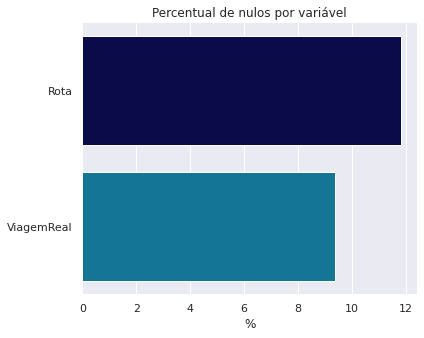

In [97]:
na_df = pd.DataFrame(distributions[['Rota', 'ViagemReal']].isna().sum())
qtd_values = distributions[['Rota', 'ViagemReal']].shape[0]
na_df = na_df.apply(lambda x: x/qtd_values*100, axis=0).reset_index()

fig, ax = plt.subplots(figsize=(6, 5))

sns.barplot(y='index', x=0, data=na_df, ax=ax, palette='ocean')
ax.set(ylabel='', xlabel='%', title='Percentual de nulos por variável')

na_df = pd.DataFrame({'NaNumbers': [distributions.Rota.isna().sum(),
                                    distributions.ViagemReal.isna().sum()],
                      'Type':['Rota', 'ViagemReal']})
sns.despine(left=True, bottom=True)

Após remover os valores nulos considerando ambas as variáveis (Rota e VIAGEM_REAL) como chave notamos uma ligeira diferença na variável Peso.
- Analisando valores mínimos: o peso transportado é quase **0 kilos** para **Rota** enquanto que para **VIAGEM_REAL** é aproximadamente **15 toneladas**.
- **Até 50%** das cargas transportadas estão em torno de **8,541 toneladas** para **Rota** e **26,259 toneladas** para **VIAGEM_REAL**  
- Analisando valores máximos: O peso para **Rota** é aproximadamente **212 toneladas**  e para a **VIAGEM_REAL 90 toneladas**

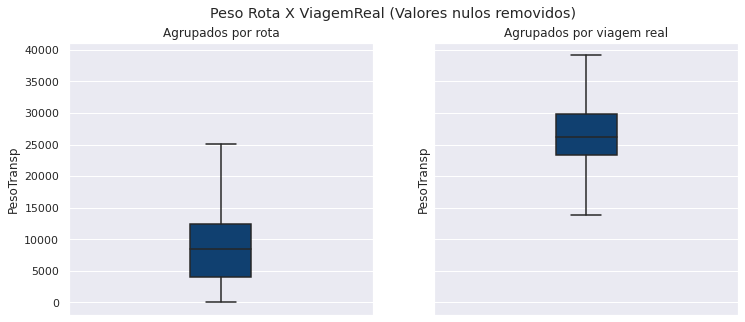

In [27]:
distributions_cp = distributions.dropna(subset=['Rota']).copy()
distributions_viagem_cp = distributions.dropna(subset=['ViagemReal']).copy()

fig, ax = plt.subplots(1, 2, figsize = (12, 5), sharey=True)

sns.boxplot(y="PesoTransp", data=distributions_cp.groupby('Rota').agg({'PesoTransp':sum}).reset_index(),
            ax=ax[0], orient='v', showfliers=False, width=0.2, palette='ocean')
sns.boxplot(y="PesoTransp", data=distributions_viagem_cp.groupby('ViagemReal').agg({'PesoTransp':sum}).reset_index(), 
            ax=ax[1], orient='v', showfliers=False, width=0.2, palette='ocean')

ax[0].set_title('Agrupados por rota')
ax[1].set_title('Agrupados por viagem real')

fig.suptitle('Peso Rota X ViagemReal (Valores nulos removidos)')
plt.show()

Com relação a **"Rota"** há uma tendência para cargas **abaixo de 20 toneladas** enquanto que para **"VIAGEM_REAL", acima de 20 toneladas**

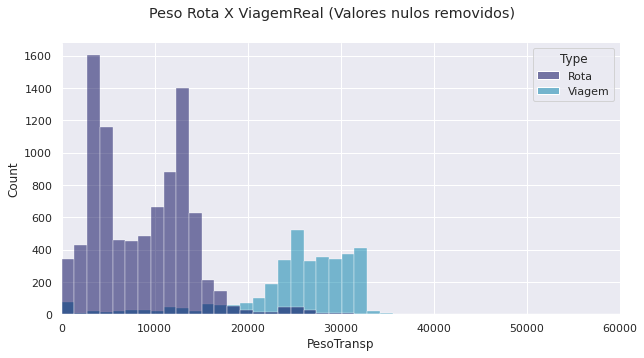

In [28]:
rota_distributions_cp =  distributions_cp.groupby('Rota').agg({'PesoTransp':sum})
rota_distributions_cp['Type'] = 'Rota'
viagem_distributions_cp =  distributions_viagem_cp.groupby('ViagemReal').agg({'PesoTransp':sum})
viagem_distributions_cp['Type'] = 'Viagem'
distributions_cp = pd.concat([rota_distributions_cp, viagem_distributions_cp]).reset_index()

fig, ax = plt.subplots(figsize = (10, 5))
sns.histplot(hue='Type', x='PesoTransp', data=distributions_cp,
             ax=ax, palette='ocean')

ax.set_xlim(0, 60000)
fig.suptitle('Peso Rota X ViagemReal (Valores nulos removidos)')
sns.despine(left=True, bottom=True)

## Outliers
As análises abaixo consideram outliers. 

In [29]:
iqr = distributions_cp.PesoTransp.describe()['75%']-distributions_cp.PesoTransp.describe()['25%']
max_lim = distributions_cp.PesoTransp.describe()['75%']+1.5*iqr

Um **outlier** específico, gerado de um agrupamento **por Rota**, se destaca com **200 toneladas** no total de recebimento

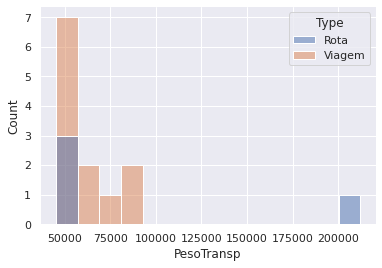

In [30]:
sns.histplot(hue='Type', x='PesoTransp', data=distributions_cp.loc[distributions_cp.PesoTransp>max_lim])
sns.despine(left=True, bottom=True)

### Por Rotas

In [31]:
outliers_viagem = distributions_cp.loc[(distributions_cp.PesoTransp>max_lim) & 
                                       (distributions_cp.Type=='Rota')]

- Todos os outliers encontrados no agrupamento por **Rota** partem do centro de distribuição de  **Betim** 
- Os meses contendo outliers são: **Abril, Julho, Agosto de 2021** e **Outubro de 2020**

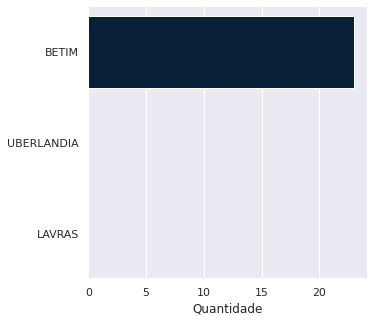

In [13]:
depositos_outliers = pd.DataFrame(distributions.loc[distributions.Rota==62156.0].groupby(
    'DataEmissaoCte').agg({'DepositoRcbto': lambda x: np.unique(list(x))}).value_counts())
depositos_outliers = depositos_outliers.reset_index()
depositos_outliers.columns = ['CD', 'Quantidade']


depositos_outliers_cp = pd.DataFrame({'CD':['UBERLANDIA', 'LAVRAS'], 'Quantidade':[0, 0]})
depositos_outliers = pd.concat([depositos_outliers, depositos_outliers_cp])

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(y='CD', x='Quantidade', data=depositos_outliers, palette='ocean', ax=ax)
ax.set(ylabel='')
sns.despine(left=True, bottom=True)

### Por VIAGEM_REAL

In [14]:
outliers_viagem = distributions_cp.loc[(distributions_cp.PesoTransp>max_lim) & 
                                       (distributions_cp.Type=='Viagem')]

**Quase 90%** dos outliers encontrados em um agrupamento por **VIAGEM_REAL** partem de **BETIM**

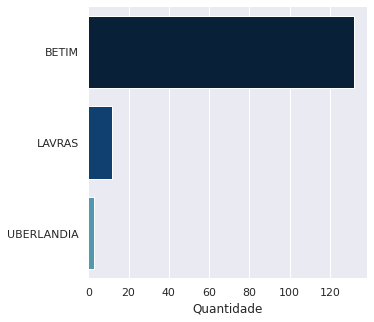

In [360]:
depositos_outliers = pd.DataFrame(distributions.loc[distributions.ViagemReal.isin(
    outliers_viagem['index'])].DepositoRcbto.value_counts()).reset_index()
depositos_outliers.columns = ['CD', 'Quantidade']

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(y='CD', x='Quantidade', data=depositos_outliers, palette='ocean', ax=ax)
ax.set(ylabel='')
sns.despine(left=True, bottom=True)

# Conclusão

Foi levantada uma questão que necessita de resposta para que possamos fazer os agrupamentos corretos:
- *Das variáveis analisadas qual deveria ser usada para fazer os agrupamentos?*